In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from pjr import *
import string
from timeit import default_timer as timer
from pprint import pprint
import cartopy.crs as ccrs

pjr.py complete


test latex syntax $a = b^2$

In [2]:
# a useful function for interpolating model to new levels
def getfld (fspec, vname, levs=None):
    """get zonal average field from model on pressure levels"""
    F =  fspec(vname,squeeze=1)            # extract fields, remove dimensions length one

    if not levs is None:
        print "interpolate to pressure levels", levs
        ps = fspec('PS',squeeze=1)
        hyam = fspec('hyam',squeeze=1)
        hybm = fspec('hybm',squeeze=1)

        start = timer()
        P = cdutil.reconstructPressureFromHybrid (ps,hyam,hybm,1.e5)
        P = P/100.; P.units = "hPa"
        stop1 = timer()
        print  "reconstruct P time = ", stop1-start
        FP1 = cdutil.logLinearInterpolation(F,P,levels=levs)
        stop2 = timer()
        print "interp time", stop2-stop1

        F = FP1

    return F;


def getdat (g0, vnameo, g1, g2, vname):
    """function to get model and obs datasets, move them to a common pressure coord grid, zonal average,
    returns:
        the observations (TP0xav)
        difference of model1 and obs (DT1xav)
        difference of model2 and obs (DT2xav)
    """
    T0 =  g0(vnameo,squeeze=1)            # get obs
    TM0 = g2(vname,squeeze=1) # get a model grid so we can do horizontal regrid obs
    T0 = T0.regrid(TM0.getGrid(),regridTool="esmf",regridMethod="linear") # horizontal regrid

    T1 = getfld (g1, vname)


    T2 = getfld (g2, vname)


    DT2 = T2 - T0
    DT1 = T1 - T0

    return T0, DT1, DT2;


    
# a class that can hold model and observational names 
class vsets(object):
    def __init__(self, name=None, mname=None, oname=None, hash={}) :
         self.name = name
         self.mname = mname
         self.oname = oname

    

In [3]:
from matplotlib import gridspec
def setup3 ():
    fig = plt.figure(figsize=(6, 9)) 
    gs = gridspec.GridSpec(3, 2, width_ratios=[20, 1]) 
    ax0 = plt.subplot(gs[0],projection=ccrs.Robinson())
    ax0.set_global() # make axis consistent with projection limits
    cx0 = plt.subplot(gs[1])
    ax1 = plt.subplot(gs[2],projection=ccrs.Robinson())
    ax1.set_global() # make axis consistent with projection limits
    cx1 = plt.subplot(gs[3])
    ax2 = plt.subplot(gs[4],projection=ccrs.Robinson())
    ax2.set_global() # make axis consistent with projection limits
    cx2 = plt.subplot(gs[5])
    return fig,[ax0,ax1,ax2],[cx0,cx1,cx2];

def defset (data, plotOpt, attribute):
    """return a sensible attribute
    if data is a numpy array, the default is an empty string
    if data is a smarter object like a cdms var it looks for an attribute
        if present that becomes the default
        else default is empty string
    if plotOpt dictionary contains a value, that is the returned quantity
    """
#    print "defset searching for ", attribute
    if hasattr(data,attribute):
        defval = getattr(data,attribute)
#        print attribute, "present, defval set to", defval
        #    variance.units = '(%s)^2'%var.units
    else:
#        print "no attribute defval set empty"
        defval = None
    val = plotOpt.get(attribute,defval)
#    print "defset returning", val
    return val;


def pltframe (data, lons=None, lats=None, axo=None, cxo=None,plotOpt=None):
    """Create a robinson projection contour plot of one variable
    axo = the axes that we make the plot on 
    data = 2d numpy array (or data structure base on numpy) ordered (latitude, pressure
)
    lons = optional mesh  of longitude (same shape as data)
    lats = 1d numpy array of latitudes (")
    plotOpt is a optional dictionary with plotting options:
      'scale_factor': multiply values with this factor before plotting
      'units': a units label for the colorbar
      'clevs': use list of values as contour intervals
      'cmap': the color map to use
      'cabv': the above color
      'cbel': the below color
      'colorbar': location of colorbar ('bot','top','left','right','None')
      'rmClev': contour level to delete; frequently Zero, see findNiceContours
      'title': a title for the plot
    """
    print "pltframe"
    if plotOpt is None: plotOpt = {}
    clevs = plotOpt.get("clevs") 
    rmClev = plotOpt.get("rmClev")
#    print "pltframe rmClev", rmClev
    if clevs is None:
#       print "clevs undefined"
        clevs = findNiceContours(data,rmClev=rmClev)
#    print "data range",data.min(), data.max()
#    print "clevs", clevs
    cmap = plotOpt.get("cmap")
    if cmap is None:
        cmap = mpl.cm.get_cmap()
    norm = mpl.colors.BoundaryNorm(clevs,cmap.N)
    scale_factor = plotOpt.get('scale_factor', 1.0)
    pdata = data * scale_factor
    # add a title
    title = defset(data, plotOpt,"title")
    if not title is None: axo.set_title(title,loc='center')
    ltitle = defset(data, plotOpt,"ltitle")
    if not ltitle is None: axo.set_title(ltitle,loc='left')
    rtitle = defset(data, plotOpt,"rtitle")
    if not rtitle is None: axo.set_title(rtitle,loc='right')
    conout = axo.contourf(lons, lats, pdata, levels=clevs, 
        norm=norm, cmap=cmap, transform=ccrs.PlateCarree(),extend='both')
    noCbar = plotOpt.get("noCbar")
    if noCbar is None:
        cabv = plotOpt.get("cabv",'green') 
        conout.cmap.set_over(cabv)
        cbel = plotOpt.get('cbel','grey')
        conout.cmap.set_under(cbel)
        cbar = fig.colorbar(conout, cax=cxo,  orientation="vertical",ticks=clevs)
        labelFontSize = "small"
        units = defset(data, plotOpt,"units")
        for t in cbar.ax.get_yticklabels():
            t.set_fontsize(labelFontSize)
            #cbar.set_label(units)
            if not units is None: cbar.ax.set_title('('+units+')',pad=5)
    else:
        cxo.axis('off')
 
    axo.coastlines()
    axo.gridlines()
    print"pltframe done"

def pltdat(TP0, DT1, DT2):
    cmap = plt.cm.viridis
    lons = TP0.getLongitude()
    lats = TP0.getLatitude()
    print TP0.info()
    pltframe(TP0, lons, lats, ax3[0], cx3[0], 
             plotOpt={'cmap':cmap,'ltitle':TP0.long_name,'rtitle':ltit0,'cbel':'grey','cabv':'orange'})
    dlevs = [-20.,-15.,-10.,-5.,-2.,-1.,1.,2.,5.,10.,15.,20.]
    cmap = diverge_map()
    pltframe(DT2, lons, lats, ax3[1], cx3[1], 
             plotOpt={'ltitle':ltit2,'clevs':dlevs,'cmap':cmap,'cbel':'grey','cabv':'magenta','noCbar':True})
    pltframe(DT1, lons, lats, ax3[2], cx3[2], 
             plotOpt={'ltitle':ltit1,'clevs':dlevs,'cmap':cmap,'cbel':'grey','cabv':'magenta'})


levs [  20.   40.   60.   80.  100.  120.  140.  160.  180.  200.  220.  240.
  260.  280.  300.  320.  340.  360.  380.  400.  420.  440.  460.  480.
  500.  520.  540.  560.  580.  600.  620.  640.  660.  680.  700.  720.
  740.  760.  780.  800.  820.  840.  860.  880.  900.  920.  940.  960.
  980. 1000.]
jname0 /global/project/projectdirs/acme/acme_diags/obs_for_acme_diags/MERRA2_ANN_1980_2016_climo.nc
jname1 /global/cscratch1/sd/leebrent/climos/output/f.e11.FAMIP.f09_f09_same_setting_LENS/rgr/f.e11.FAMIP.f09_f09_same_setting_LENS_ANN_climo.nc
jname2 /global/cscratch1/sd/leebrent/climos/output/20180316.DECKv1b_A1.ne30_oEC.edison/rgr/20180316.DECKv1b_A1.ne30_oEC.edison_ANN_climo.nc
obs varlist ['va', 'rsds', 'tas', 'rsdscs', 'zg', 'hfss', 'lon_bnds', 'height', 'rlutcs', 'prw', 'hfls', 'time_bnds', 'rlut', 'rlus', 'rlds', 'vas', 'lat_bnds', 'uas', 'ta', 'pr', 'psl', 'rsdt', 'hur', 'rsutcs', 'tauv', 'tauu', 'rsus', 'wap', 'ua', 'rsut']
i Surface Air Temperature
*** Description of Sla

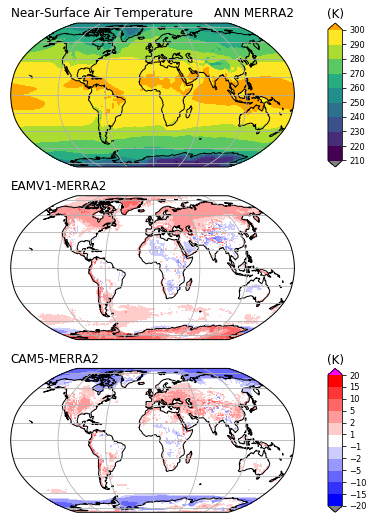

In [4]:
#----------------------------------------------------------
# define the metadata that controls the analysis and plotting
# identify the levels that we will interpolate to
levs = findNiceContours(np.array([1000.,10]),50,rmClev=0.) # in hPa
print "levs", levs
nlevs = cdms2.createAxis(levs) # make a cdms vertical grid to remap to

# the season to plot
seas = "DJF"
seas = "JJA"
seas = "ANN"

# observations
jname0 = '/global/project/projectdirs/acme/acme_diags/obs_for_acme_diags/MERRA2_ANN_1980_2016_climo.nc'
jname0 = '/global/project/projectdirs/acme/acme_diags/obs_for_acme_diags/MERRA2_'+seas+'_1980_2016_climo.nc'
ltit0 = seas+" MERRA2"
print "jname0", jname0

# model1 dataset
dir1 = "/global/cscratch1/sd/leebrent/climos/output/f.e11.FAMIP.f09_f09_same_setting_LENS/rgr/"
f1 = "f.e11.FAMIP.f09_f09_same_setting_LENS_ANN_197912_200511_climo.nc"
f1 = "f.e11.FAMIP.f09_f09_same_setting_LENS_"+seas+"_climo.nc"
ltit1 = "CAM5-MERRA2"
jname1 = dir1+f1
print "jname1", jname1

# model2 dataset
dir2 = '/global/cscratch1/sd/leebrent/climos/output/20180316.DECKv1b_A1.ne30_oEC.edison/rgr/'
f2 = '20180316.DECKv1b_A1.ne30_oEC.edison_ANN_197912_200411_climo.nc'
f2 = '20180316.DECKv1b_A1.ne30_oEC.edison_'+seas+'_climo.nc'
ltit2 = "EAMV1-MERRA2"
jname2 = dir2+f2
print "jname2", jname2  

# a list of variables and the names they are called in the model and obs dataset files
vlist = [] #create an empty list
vlist.append(vsets("Surface Air Temperature", "TREFHT","tas"))
#vlist.append(vsets("Surface Temperature", "T", "tsrf"))
#vlist.append(vsets("", "U", "ua"))

g0 = cdms2.open(jname0);
varlist = g0.listvariables();
print "obs varlist", varlist
dims = g0.listdimension();
g1 = cdms2.open(jname1);
g2 = cdms2.open(jname2)

fig, ax3, cx3 = setup3()
for i in vlist:
    print "i", i.name
    pltname = "Roblatlon_"+i.name+"_"+seas+"_MERRAvsModels.pdf"
    TP0, DT1, DT2 = getdat(g0, i.oname, g1, g2, i.mname)
    pltdat(TP0, DT1, DT2)
    print "figure being saved to ", pltname
    plt.savefig(pltname,type="pdf",bbox_inches='tight')
    print "done with"+i.name
    #break


jname0 /global/project/projectdirs/acme/acme_diags/obs_for_acme_diags/ceres_ebaf_toa_v4.0_DJF_200101_201512_climo.nc
jname1 /global/cscratch1/sd/leebrent/climos/output/f.e11.FAMIP.f09_f09_same_setting_LENS/rgr/f.e11.FAMIP.f09_f09_same_setting_LENS_ANN_climo.nc
jname2 /global/cscratch1/sd/leebrent/climos/output/20180316.DECKv1b_A1.ne30_oEC.edison/rgr/20180316.DECKv1b_A1.ne30_oEC.edison_ANN_climo.nc
obs varlist ['cldtau_total_day_mon', 'rlut', 'toa_cre_net_mon', 'toa_cre_lw_mon', 'rlutcs', 'toa_net_all_mon', 'rsdt', 'rsutcs', 'cldtemp_total_daynight_mon', 'cldpress_total_daynight_mon', 'toa_net_clr_mon', 'toa_cre_sw_mon', 'rsut', 'cldarea_total_daynight_mon']
i SW_TOA_CRE
pltframe
pltframe done
diff range [-104.51919   -79.30994   119.522896  104.71828 ]
dlevs.size 22
diff contour levs [-90. -80. -70. -60. -50. -40. -30. -20. -10.  10.  20.  30.  40.  50.
  60.  70.  80.  90.]
pltframe
pltframe done
pltframe
pltframe done
figure being saved to  Roblatlon_SW_TOA_CRE_ANN_EBAFSvsModels.pdf


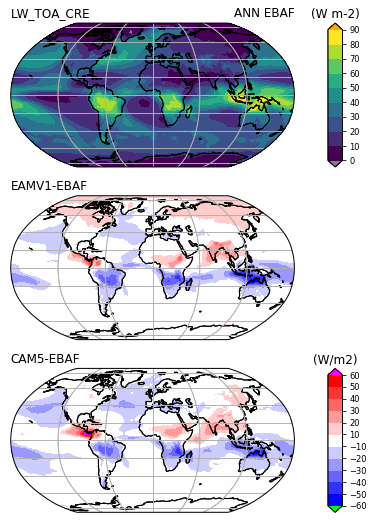

In [18]:
def pltdatEBAF(TP0, DT1, DT2):
    cmap = plt.cm.viridis
    lons = TP0.getLongitude()
    lats = TP0.getLatitude()
    pltframe(TP0, lons, lats, ax3[0], cx3[0], 
             plotOpt={'cmap':cmap,'ltitle':i.name,'rtitle':ltit0,'cbel':'grey','cabv':'orange'})
    dlevs = [-20.,-15.,-10.,-5.,5.,10.,15.,20.]
    dtrng = np.array([DT1.min(),DT2.min(),DT1.max(), DT2.max()])
    dlevs = findNiceContours(np.array([DT1.min(),DT2.min(),DT1.max(), DT2.max()]),20, rmClev=0., sym=True)
    print "diff range", dtrng
    print "dlevs.size", dlevs.size
    if dlevs.size >=18: dlevs = dlevs[2:-2]
    print "diff contour levs", dlevs
    cmap = diverge_map()
    pltframe(DT2, lons, lats, ax3[1], cx3[1], 
             plotOpt={'ltitle':ltit2,'clevs':dlevs,'cmap':cmap,'cbel':'lime','cabv':'magenta','noCbar':True})
    pltframe(DT1, lons, lats, ax3[2], cx3[2], 
             plotOpt={'ltitle':ltit1,'clevs':dlevs,'cmap':cmap,'cbel':'lime','cabv':'magenta'})
    
#----------------------------------------------------------
# define the metadata that controls the analysis and plotting
# the season to plot
seas = "JJA"
seas = "DJF"
seas = "ANN"

# observations
jname0 = '/global/project/projectdirs/acme/acme_diags/obs_for_acme_diags/ceres_ebaf_toa_v4.0_ANN_200101_201612_climo.nc'
jname0 = '/global/project/projectdirs/acme/acme_diags/obs_for_acme_diags/ceres_ebaf_toa_v4.0_JJA_200106_201608_climo.nc'
jname0 = '/global/project/projectdirs/acme/acme_diags/obs_for_acme_diags/ceres_ebaf_toa_v4.0_DJF_200101_201512_climo.nc'
#jname0 = '/global/project/projectdirs/acme/acme_diags/obs_for_acme_diags/ceres_ebaf_toa_v2.8_DJF_200101_201612_climo.nc'
ltit0 = seas+" EBAF"
print "jname0", jname0

# model1 dataset
dir1 = "/global/cscratch1/sd/leebrent/climos/output/f.e11.FAMIP.f09_f09_same_setting_LENS/rgr/"
f1 = "f.e11.FAMIP.f09_f09_same_setting_LENS_"+seas+"_climo.nc"
ltit1 = "CAM5-EBAF"
jname1 = dir1+f1
print "jname1", jname1

# model2 dataset
dir2 = '/global/cscratch1/sd/leebrent/climos/output/20180316.DECKv1b_A1.ne30_oEC.edison/rgr/'
f2 = '20180316.DECKv1b_A1.ne30_oEC.edison_'+seas+'_climo.nc'
ltit2 = "EAMV1-EBAF"
jname2 = dir2+f2
print "jname2", jname2  

# a list of variables and the names they are called in the model and obs dataset files
vlist = [] #create an empty list
vlist.append(vsets("SW_TOA_CRE", "SWCF","toa_cre_sw_mon"))
vlist.append(vsets("LW_TOA_CRE", "LWCF","toa_cre_lw_mon"))
#vlist.append(vsets("Surface Temperature", "T", "tsrf"))
#vlist.append(vsets("", "U", "ua"))

g0 = cdms2.open(jname0);
varlist = g0.listvariables();
print "obs varlist", varlist
#var = g0('toa_cre_lw_mon')
#print "varinfo", var.info()

dims = g0.listdimension();
g1 = cdms2.open(jname1);
g2 = cdms2.open(jname2)

fig, ax3, cx3 = setup3()
for i in vlist:
    print "i", i.name
    pltname = "Roblatlon_"+i.name+"_"+seas+"_EBAFSvsModels.pdf"
    TP0, DT1, DT2 = getdat(g0, i.oname, g1, g2, i.mname)
    pltdatEBAF(TP0, DT1, DT2)
    plt.draw()
    print "figure being saved to ", pltname
    plt.savefig(pltname,type="pdf",bbox_inches='tight')
    print "done with"+i.name
    


seas ANN
jnametoa /global/project/projectdirs/acme/acme_diags/obs_for_acme_diags/ceres_ebaf_toa_v4.0_ANN_200101_201512_climo.nc
jnamesrf /global/project/projectdirs/acme/acme_diags/obs_for_acme_diags/ceres_ebaf_surface_v4.0_ANN_200101_201512_climo.nc
toa varlist ['cldtau_total_day_mon', 'rlut', 'toa_cre_net_mon', 'toa_cre_lw_mon', 'rlutcs', 'toa_net_all_mon', 'rsdt', 'rsutcs', 'cldtemp_total_daynight_mon', 'cldpress_total_daynight_mon', 'toa_net_clr_mon', 'toa_cre_sw_mon', 'rsut', 'cldarea_total_daynight_mon']
srf varlist ['rlus', 'rsuscs', 'rsdscs', 'sfc_net_lw_clr_mon', 'sfc_net_tot_all_mon', 'sfc_net_lw_all_mon', 'sfc_net_sw_all_mon', 'rldscs', 'rsds', 'rlds', 'rsus', 'rluscs', 'sfc_net_tot_clr_mon', 'sfc_net_sw_clr_mon']
jname1 /global/cscratch1/sd/leebrent/climos/output/f.e11.FAMIP.f09_f09_same_setting_LENS/rgr/f.e11.FAMIP.f09_f09_same_setting_LENS_ANN_climo.nc
jname2 /global/cscratch1/sd/leebrent/climos/output/20180316.DECKv1b_A1.ne30_oEC.edison/rgr/20180316.DECKv1b_A1.ne30_oEC.e

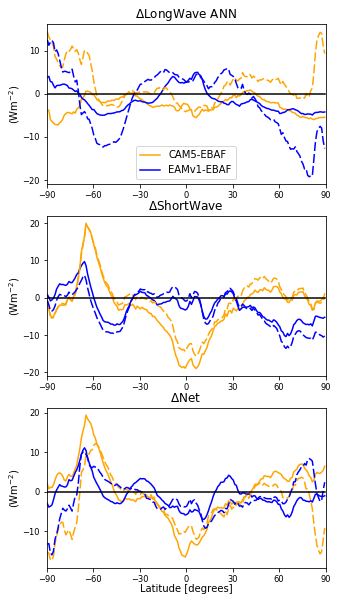

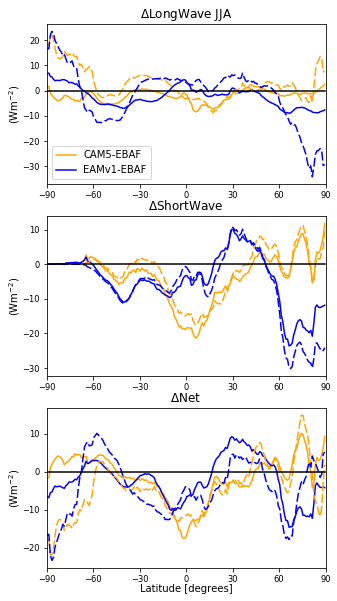

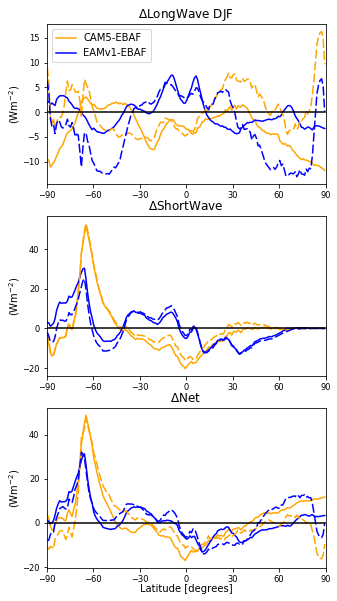

In [16]:
def pltdatL(TP0, DT1, DT2):
    lats = TP0.getLatitude()
    lats = lats[:]
    print "lats", lats
    print "latsshape", lats.shape
    print "ax", ax
    print "DT1shape", DT1.shape
    ax.plot(lats, DT1.data);
    ax.plot(lats, DT2.data);
       
def getdatL(fspec,varname, ogrid):
    """get data, regrid it to output grid, then return zonal average"""
    V = fspec(varname,squeeze=1)
#    print "getdat varname, shape, globalavg", varname, V.shape, cdutil.averager(V,axis="xy")
#    latstmp = V.getLatitude()[:]
#    print "latstmp shape and lats", latstmp.shape, latstmp
#    lat40 = np.argmin(abs(latstmp-40.))
#    v40b = V[lat40,:]
#    print "v40b lat, shape, mean", latstmp[lat40], v40b.shape, np.mean(v40b)
#   print "lat40, and latstmp[lat40]", lat40, latstmp[lat40]
    V = V.regrid(ogrid,regridTool="esmf",regridMethod="bilinear")
#    V = V.regrid(ogrid,regridTool="esmf",regridMethod="conserve")
#    print "after regrid"
#    print "getdat varname, shape", varname, V.shape, cdutil.averager(V,axis="xy")
#    latstmp = V.getLatitude()[:]
#    print "latstmp shape and lats", latstmp.shape, latstmp
#    lat40 = np.argmin(abs(latstmp-40.))
#    v40b = V[lat40,:]
#    print "v40b lat, shape, mean", latstmp[lat40], v40b.shape, np.mean(v40b)
    V = cdutil.averager(V,axis="x")
#    print "after averager"
#    print "getdat varname, shape", varname, V.shape, cdutil.averager(V,axis="y")
#    latstmp = V.getLatitude()[:]
#    print "latstmp shape and lats", latstmp.shape, latstmp
#    lat40 = np.argmin(abs(latstmp-40.))
#    v40b = V[lat40]
#    print "v40b lat, shape, mean", 'float', latstmp[lat40], np.mean(v40b),'\n\n\n'
    return V;

#----------------------------------------------------------
# define the metadata that controls the analysis and plotting
# the season to plot
seaslist = ["ANN","JJA","DJF"]

# observations
jdir = '/global/project/projectdirs/acme/acme_diags/obs_for_acme_diags/'

toadict = {'JJA':'ceres_ebaf_toa_v4.0_JJA_200106_201508_climo.nc',
        'DJF':'ceres_ebaf_toa_v4.0_DJF_200101_201512_climo.nc',
        'ANN':'ceres_ebaf_toa_v4.0_ANN_200101_201512_climo.nc'}



srfdict = {'ANN':'ceres_ebaf_surface_v4.0_ANN_200101_201512_climo.nc',
           'ANNOFF':'ceres_ebaf_toa_v2.8_ANN_200101_201612_climo.nc',
        'DJF':'ceres_ebaf_surface_v4.0_DJF_200101_201512_climo.nc',
        'JJA':'ceres_ebaf_surface_v4.0_JJA_200106_201508_climo.nc'}


# a list of variables and the names they are called in the model and obs dataset files
vlist = [] #create an empty list
vlist.append(vsets("LW_TOA", "FLUT","rlut"))
vlist.append(vsets("SW_TOA", "FSNT","rsut"))
#vlist.append(vsets("Surface Temperature", "T", "tsrf"))
#vlist.append(vsets("", "U", "ua"))

for seas in seaslist:
    print "seas", seas

    jnametoa = jdir+toadict[seas]
    print "jnametoa", jnametoa

    jnamesrf = jdir+srfdict[seas]
    print "jnamesrf", jnamesrf
    ltit0 = seas+" EBAF"
    gtoa = cdms2.open(jnametoa);
    varlist = gtoa.listvariables();
    print "toa varlist", varlist

    gsrf = cdms2.open(jnamesrf);
    varlist = gsrf.listvariables();
    print "srf varlist", varlist


    # model1 dataset
    dir1 = "/global/cscratch1/sd/leebrent/climos/output/f.e11.FAMIP.f09_f09_same_setting_LENS/rgr/"
    f1 = "f.e11.FAMIP.f09_f09_same_setting_LENS_ANN_197912_200511_climo.nc"
    f1 = "f.e11.FAMIP.f09_f09_same_setting_LENS_"+seas+"_climo.nc"
    ltit1 = "CAM5-EBAF"
    jname1 = dir1+f1
    print "jname1", jname1

    # model2 dataset
    dir2 = '/global/cscratch1/sd/leebrent/climos/output/20180316.DECKv1b_A1.ne30_oEC.edison/rgr/'
    f2 = '20180316.DECKv1b_A1.ne30_oEC.edison_ANN_197912_200411_climo.nc'
    f2 = '20180316.DECKv1b_A1.ne30_oEC.edison_'+seas+'_climo.nc'
    ltit2 = "EAMV1-EBAF"
    jname2 = dir2+f2
    print "jname2", jname2  

    #print "varinfo", var.info()
    #dims = g0.listdimension();
    g1 = cdms2.open(jname1);
    g2 = cdms2.open(jname2)


    PS = g2('PS',squeeze=1)
    ogrid = PS.getGrid()  # output grid at model resolution
    rlut = gtoa('rlut')
    ogrid = rlut.getGrid() # output grid at EBAF resolution
    print "ogrid shape", ogrid.shape

    # set variables to use the CESM sign convention
    # solar fluxes are positive into the surface
    # longwave fluxes are positive away from the surface
    FLNTO = getdatL(gtoa,'rlut',ogrid)
    RSUT = getdatL(gtoa,'rsut',ogrid)
    RSDT = getdatL(gtoa,'rsdt',ogrid)
    FSNTO = RSDT-RSUT
    #print "FSNTM1", FSNTM1[0:10]
    #print "RSDT", FSNTO[0:10]
    #print "RSUT", RSUT[0:10]
    #print "FSNTO", FSNTO[0:10]

    FLNSO = -getdatL(gsrf,'sfc_net_lw_all_mon',ogrid)
    FSNSO = getdatL(gsrf,'sfc_net_sw_all_mon',ogrid)

    #print "flnto.shape", FLNTO.shape
    #print "getting EAMv1"
    FLNTM2 = getdatL(g2,'FLUT',ogrid)
    FLNSM2 = getdatL(g2,'FLNS',ogrid)
    FSNTM2 = getdatL(g2,'FSNT',ogrid)
    FSNSM2 = getdatL(g2,'FSNS',ogrid)
    #print "getting CAM5"
    FLNTM1 = getdatL(g1,'FLUT',ogrid)
    FLNSM1 = getdatL(g1,'FLNS',ogrid)
    FSNTM1 = getdatL(g1,'FSNT',ogrid)
    FSNSM1 = getdatL(g1,'FSNS',ogrid)

    #ax.plot(latsm, FLNTM1.data,label='M1');
    #ax.plot(latsm, FLNTM2.data,label='M2');
    #ax.plot(latsm, FLNTO.data,label='EBAF');

    #plt.title('FLNT')
    #plt.legend()

    #fig = plt.figure()
    #ax = plt.axes

    print "ModelLW TOA", cdutil.averager(FLNTM1,axis="y")
    print "OBS LW TOA", cdutil.averager(FLNTO,axis="y")
    print "ModelSW TOA", cdutil.averager(FSNTM1,axis="y")
    print "OBS SW TOA", cdutil.averager(FSNTO,axis="y")
    print "ModelLW srf", cdutil.averager(FLNSM1,axis="y")
    print "OBS LW srf", cdutil.averager(FLNSO,axis="y")
    print "ModelSW srf", cdutil.averager(FSNSM1,axis="y")
    print "OBS SW srf", cdutil.averager(FSNSO,axis="y")

    # TOA
    DFLNT1 = FLNTM1-FLNTO
    DFLNT2 = FLNTM2-FLNTO
    DFSNT1 = FSNTM1-FSNTO
    DFSNT2 = FSNTM2-FSNTO
    # surface
    DFLNS1 = FLNSM1-FLNSO
    DFLNS2 = FLNSM2-FLNSO
    DFSNS1 = FSNSM1-FSNSO
    DFSNS2 = FSNSM2-FSNSO
    # TOA net
    FNETTM1 = FSNTM1-FLNTM1
    FNETTM2 = FSNTM2-FLNTM2
    FNETTO = FSNTO-FLNTO
    DFNETTM1 = FNETTM1-FNETTO
    DFNETTM2 = FNETTM2-FNETTO
    # surface net
    FNETSM1 = FSNSM1-FLNSM1
    FNETSM2 = FSNSM2-FLNSM2
    FNETSO = FSNSO-FLNSO
    DFNETSM1 = FNETSM1-FNETSO
    DFNETSM2 = FNETSM2-FNETSO
    #print "FSNSM1", FSNSM1[0:10]
    #print "FSNSO", FSNSO[0:10]
    #print "FSNTM1", FSNTM1[0:10]
    #print "FSNTO", FSNTO[0:10]
    latsm = DFLNT1.getLatitude()[:]
    #fig = plt.figure()
    #ax = plt.axes()
    fig = plt.figure(figsize=(5., 10.), facecolor='white')
    axest = fig.add_subplot(311)
    axesm = fig.add_subplot(312)
    axesb = fig.add_subplot(313)
    m2color = 'blue'
    m1color = 'orange'
    labelFontSize='small'
    ax = axest
    ax.plot(latsm, DFLNT1.data,label='CAM5-EBAF',color=m1color);
    ax.plot(latsm, DFLNT2.data,label='EAMv1-EBAF',color=m2color);
    ax.plot(latsm, DFLNS1.data, dashes=[6, 2],color=m1color);
    ax.plot(latsm, DFLNS2.data, dashes=[6, 2],color=m2color);
    #ax.plot(latsm, DS1.data,label='CAM5-EBAF');
    #ax.plot(latsm, DS2.data,label='EAMv1-EBAF');
    ax.plot(latsm, np.zeros(latsm.size),color='black')
    ax.set_ylabel('(Wm$^{-2}$)')
    ax.labelsize=labelFontSize
    ax.yaxis.labelpad = 0.0
    #ax.xaxis.labelpad = 0.05
    ax.set_xlim(-90.,90.)
    xloc = mpl.ticker.FixedLocator(np.arange(-90.,91.,30.))
    ax.xaxis.set_major_locator(xloc)
    for t in ax.get_xticklabels():
        t.set_fontsize(labelFontSize)
    ax.legend()
    for t in ax.get_yticklabels():
        t.set_fontsize(labelFontSize)
    ax.set_title('$\Delta$LongWave '+seas)

    ax = axesm
    ax.plot(latsm, DFSNT1.data,label='CAM5-EBAF',color=m1color);
    ax.plot(latsm, DFSNT2.data,label='EAMv1-EBAF',color=m2color);
    ax.plot(latsm, DFSNS1.data, dashes=[6, 2],color=m1color);
    ax.plot(latsm, DFSNS2.data, dashes=[6, 2],color=m2color);
    #ax.plot(latsm, DS1.data,label='CAM5-EBAF');
    #ax.plot(latsm, DS2.data,label='EAMv1-EBAF');
    ax.plot(latsm, np.zeros(latsm.size),color='black')
    ax.set_ylabel('(Wm$^{-2}$)')
    ax.labelsize=labelFontSize
    ax.yaxis.labelpad = 0.0
    #ax.set_xlabel('Latitude [degrees]')
    #ax.xaxis.labelpad = 0.05
    ax.set_xlim(-90.,90.)
    xloc = mpl.ticker.FixedLocator(np.arange(-90.,91.,30.))
    ax.xaxis.set_major_locator(xloc)
    for t in ax.get_xticklabels():
        t.set_fontsize(labelFontSize)
    for t in ax.get_yticklabels():
        t.set_fontsize(labelFontSize)

    ax.set_title('$\Delta$ShortWave')

    ax = axesb
    ax.plot(latsm, DFNETTM1.data,label='CAM5-EBAF',color=m1color);
    ax.plot(latsm, DFNETTM2.data,label='EAMv1-EBAF',color=m2color);
    ax.plot(latsm, DFNETSM1.data, dashes=[6, 2],color=m1color);
    ax.plot(latsm, DFNETSM2.data, dashes=[6, 2],color=m2color);
    #ax.plot(latsm, DS1.data,label='CAM5-EBAF');
    #ax.plot(latsm, DS2.data,label='EAMv1-EBAF');
    ax.plot(latsm, np.zeros(latsm.size),color='black')
    ax.set_xlabel('Latitude [degrees]')
    ax.set_ylabel('(Wm$^{-2}$)')
    ax.labelsize=labelFontSize
    ax.yaxis.labelpad = 0.0
    ax.xaxis.labelpad = 0.05
    ax.set_xlim(-90.,90.)
    xloc = mpl.ticker.FixedLocator(np.arange(-90.,91.,30.))
    ax.xaxis.set_major_locator(xloc)
    for t in ax.get_xticklabels():
        t.set_fontsize(labelFontSize)
    for t in ax.get_yticklabels():
        t.set_fontsize(labelFontSize)

    ax.set_title('$\Delta$Net')

    pltname = 'ZL_radfluxes_'+seas+'.pdf'
    print "figure being saved to ", pltname
    plt.savefig(pltname,type="pdf",bbox_inches='tight')
    print "done with ", seas+"\n\n\n"

